<a href="https://colab.research.google.com/github/Hotckiss/image_analysis/blob/master/Copy_of_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №4

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **HSE2020 HW4 <Фамилия Имя>**

soft deadline: 15.03.2020T23:59:00+0300

hard deadline: 22.03.2020T23:59:00+0300

# Поиск изображений по содержанию (30 (+20) баллов)

Вам предстоит построить систему, которая позволит выполнить поиск изображений по содержанию в базе Corel-10k, которая приложена к домашнему заданию. База состоит из 100 классов изображений по 100 изображений в каждом классе. Имя каждого изображения в базе состоит из **X.JPEG**, где X - число от 1 до 10000. Изображения из одного класса лежат подряд в промежутке 1-100, 101-200, и тд. В файле **test.dat** лежит список картинок, которые не должны участвовать в построении поисковой базы, но по которым надо будет сделать 1000 поисковых запросов. Ограничение по памяти -- 2Гб.

1. По изображениям не попавшим в **test.dat** посчитайте дескриптор с помощью алгоритма GIST.
   
2. Разбейте дескрипторы всех изображений на 100 кластеров с помощью K-Means.

3. Для каждого кластера постройте функцию хэширования (LSH), с помощью которой закодируйте каждое изображение в тренировочной выборке.

5. Релизуйте функцию `retrieve` продемонстрируйте работу `retrieve` на 5-ти случайных изображениях из **test.dat**. Замерьте время исполнения поискового запроса. Сделайте возможность вызвать `retrieve` без построения индекса, то есть приложите в решение индексированную базу, если только время построения индекса не укладывается в 1 минуту.  

5. Сделайте 1000 запросов изображениями из файла **test.dat**.  Замерьте среднее время исполнения поискового запроса в colab ноутбуке.

    
6. Для каждого запроса нужно оценить MAPk, где k=10 и посчитать среднее значение этой величины по всем запросам.

Так же за это задание можно получить еще до 20-ти дополнительных баллов. 

1. Вы можете сделать быстрый поиск. Если качество вашего поиска окажется выше, чем медиана качества по всем поисковым движкам, то вы принимаете участие в 
борьбе за 10 призовых баллов. Первое место получает 10 баллов, второе 9, третье 8 и т.д. 

2. Вы можете сделать хороший поиск. Если ваш поиск окажется быстрее, чем медиана среднего времени работы других участников, то вы принимаете участие в борьбе за точный поиск. Распределение баллов здесь будет такое же как и в конкурсе на скорость. 

Для достижения лучших результатов вам придется регулировать несколько параметров алгоритма:
- Дескриптор. Можете взять что угодно вместо GIST
- Количество кластеров k-means
- Длину кода LSH
- etc 

Принципиально нельзя использовать готовые поисковые движки. И помните о том, что время поиска очень важный параметр.

In [0]:
# installation of pyleargist
!wget http://www.fftw.org/fftw-3.3.8.tar.gz
!tar -xzvf fftw-3.3.8.tar.gz
%cd fftw-3.3.8
!./configure --enable-single --enable-shared
!make
!make install
%cd ../
!wget https://github.com/tuttieee/lear-gist-python/archive/master.zip
!unzip master.zip
%cd ./lear-gist-python-master
!wget http://lear.inrialpes.fr/src/lear_gist-1.2.tgz
!tar zxvf lear_gist-1.2.tgz
!sudo apt-get install libfftw3-3
!python setup.py build_ext
!python setup.py install

In [138]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=a4dc15cf9cc1bd26c26b5b348134fb983a54ae415558174dabdd511ffd3bb941
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [0]:
import gist
import numpy as np
import cv2
from sklearn.cluster import KMeans
import random
import os
import torch
import matplotlib.pylab as plt
import time
from datetime import timedelta
from mpl_toolkits.axes_grid1 import ImageGrid
import ml_metrics as metrics
import zipfile
from tqdm.auto import tqdm

In [140]:
def make_reproducible(seed, make_cuda_reproducible):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2341
make_reproducible(SEED, False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [0]:
RESIZE=(64, 64)
GIST_PARAMS = {'nblocks': 4, 'orientations_per_scale': [8, 8, 8, 8]}
N_CLUSTERS = 100
LSH_RANDOM_VECTORS_NUM = 10
LSH_BUCKETS_NUM = 3
N_RETRIEVE_SHOW = 10
N_RETRIEVE_MEASURE_TIME = 10
N_RETRIEVE_MAPK = 10

In [0]:
def configure_gist_descriptor(gist_params):
    def gist_descriptor(img):
        return gist.extract(img, gist_params['nblocks'], gist_params['orientations_per_scale'])
    return gist_descriptor

In [0]:
class ImageWrapper:
    def __init__(self, _path, data):
        self.full_name = _path.split('/')[-1].split('.')[0].split('_')
        self.data = data

    def label(self):
        return int(self.full_name[0])

    def name(self):
        return self.full_name[1] + '.JPEG'

    def image(self):
        res = cv2.imdecode(np.frombuffer(self.data, np.uint8), cv2.IMREAD_COLOR) 
        res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
        res = cv2.resize(res, RESIZE)
        return res

In [0]:
with open('hw4/test.dat', 'r') as f:
    TEST_IMAGE_NAMES = [l.strip() for l in f]
    

In [216]:
wrappers = []
with zipfile.ZipFile('hw4/Corel.zip', 'r') as zip_file:
    for filepath in tqdm(zip_file.namelist()):
        if filepath.endswith('.jpg'):
            wrappers.append(ImageWrapper(filepath, zip_file.read(filepath)))

In [0]:
TRAIN_X, TEST_X, TRAIN_Y, TEST_Y = [], [], [], []
for w in wrappers:
    if w.name() in TEST_IMAGE_NAMES:
        TEST_X.append(w.image())
        TEST_Y.append(w.label())
    else:
        TRAIN_X.append(w.image())
        TRAIN_Y.append(w.label())
TRAIN_X, TEST_X, TRAIN_Y, TEST_Y = np.array(TRAIN_X), np.array(TEST_X), np.array(TRAIN_Y), np.array(TEST_Y)

In [226]:
GIST_TRAIN_X = []
for i in tqdm(range(len(images))):
    GIST_TRAIN_X.append(gist.extract(images[i], 4, [8, 8, 8, 8]))
GIST_TRAIN_X = np.array(GIST_TRAIN_X)

In [245]:
def apply_descriptor(images, descriptor):
  descriptor = lambda t: gist.extract(t, 4, [8, 8, 8, 8])
  from tqdm.auto import tqdm
  print('Applying discriptor to images...')
  descripted_example = descriptor(images[0])
  result = np.empty((len(images), descripted_example.shape[0]), dtype=descripted_example.dtype)
  for i in tqdm(range(len(images))):
    result[i] = descriptor(images[i])
  return result

GIST_TRAIN_X = apply_descriptor(TRAIN_X, GIST_DESCRIPTOR)

Applying discriptor to images...


In [0]:
KMEANS = KMeans(n_clusters=N_CLUSTERS, random_state=SEED).fit(GIST_TRAIN_X)

In [0]:
def get_dict_based_on_clusters(kmeans, data):
  d = dict()
  for i, label in enumerate(kmeans.labels_):
    if label not in d:
      d[label] = {'indices': [], 'data': []}
    d[label]['data'].append(data[i])
    d[label]['indices'].append(i)
  for label in d:
    d[label]['data'] = np.array(d[label]['data'])
    d[label]['indices'] = np.array(d[label]['indices'])
  return d

In [0]:
CLUSTERED_GIST_TRAIN_X = get_dict_based_on_clusters(KMEANS, GIST_TRAIN_X)

In [0]:
def apply_lsh_to_each_cluster(clustered_data, num_of_random_vectors):
  d = dict()
  for label, cluster_dict in clustered_data.items():
    cluster_data = cluster_dict['data']
    indices = cluster_dict['indices']
    lsh_model = LSH(cluster_data)
    lsh_model.train(num_of_random_vectors)
    d[label] = {'indices': indices, 'lsh_model': lsh_model}
  return d

In [0]:
LSH_GIST_TRAIN_X = apply_lsh_to_each_cluster(CLUSTERED_GIST_TRAIN_X, num_of_random_vectors=LSH_RANDOM_VECTORS_NUM)

In [0]:
def add_cluster_centers(kmeans, d):
  new_d = dict()
  new_d['kmeans'] = kmeans
  new_d['clusters'] = d
  return new_d

def create_index(descriptor_params, kmeans, lsh_data):
  index = add_cluster_centers(kmeans, lsh_data)
  index['descriptor_params'] = descriptor_params
  return index

In [0]:
INDEX = create_index(GIST_PARAMS, KMEANS, LSH_GIST_TRAIN_X)

In [0]:
def save_index(index):
  import pickle
  with open('hw4/index.pkl', 'wb') as f:
    pickle.dump(index, f)
  return

def load_index():
  import pickle
  with open('hw4/index.pkl', 'rb') as f:
    return pickle.load(f)

In [0]:
save_index(INDEX)

In [0]:
def get_index_size_in_gb():
  return os.path.getsize('hw4/index.pkl') / (1024*1024*1024)

In [256]:
get_index_size_in_gb()

0.06380710937082767

In [0]:
def retrieve(sample, n, buckets_num=LSH_BUCKETS_NUM, index=None):
  def retrieve_image_idx_from_lsh(lsh_model, indices):
    retrieved = lsh_model.query(sample, n, buckets_num)
    image_indices = np.array([indices[idx] for idx in retrieved['id'].keys()])
    return image_indices

  if index is None:
    index = load_index()
  descriptor = configure_gist_descriptor(index['descriptor_params'])
  sample = descriptor(sample)
  label = index['kmeans'].predict(sample.reshape(1, -1))
  lsh_dict = index['clusters'][int(label)]
  print(lsh_dict['indices'])
  images_idx = retrieve_image_idx_from_lsh(lsh_dict['lsh_model'], lsh_dict['indices'])
  return images_idx

In [0]:
def show_retrieve():
  index = load_index()
  samples_indices = random.sample([i for i in range(len(TEST_X))], k=5)
  samples = TEST_X[samples_indices]
  for i, sample in enumerate(samples):
    print(f'{i + 1} query')
    start = time.time()
    images_idx = retrieve(sample, n=N_RETRIEVE_SHOW, index=index)
    end = time.time()
    print(f'Duration: {end - start}')
    images = TRAIN_X[images_idx]
    plt.imshow(sample)
    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, N_RETRIEVE_SHOW), axes_pad=0.1)
    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()
    print()
    print()

1 query
[ 139  140  141  159  160  171  452  633  675  676  695  714  880  905
 1534 1537 1544 1545 1547 1548 1551 1554 1555 1556 1565 1567 1582 1583
 1584 1587 1594 1595 1599 1612 1616 1623 1624 1636 1639 1641 1647 1666
 1670 1675 1677 1680 2000 2165 2194 2223 2238 2239 2240 2241 2242 2292
 2401 2402 2423 2863 3560 3961 3963 3974 3976 3977 3979 3986 4007 4345
 5876 5911 5922 6245 6257 6258 6271 6406 6693 6780 6792 6811 7086 7350
 7399 7623 7681 7802 7920 7924 7943 7964 7965 7966 7967 7973 7981 7982
 7983 7991 8146 8169 8350 8502 8571 8572 8580 8970]
Duration: 0.02940511703491211


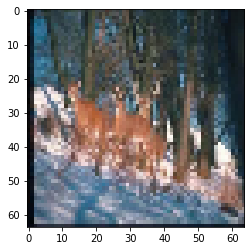

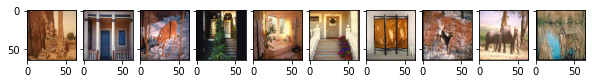



2 query
[  17   23   24   25   72  133  180  186  201  203  252  365  366  374
  382  384  389  404  407  423  425  430  433  438  439  441  442  444
  446  448  449  630  642  644  653  672  683  690  693  696  697  698
  700  783  800  943 1078 1419 1631 1658 1799 1829 1873 1904 1906 1910
 2175 2176 2263 2274 2275 2283 2341 2348 2376 2393 2395 2426 2429 2632
 2649 2678 2688 2791 2799 2828 3231 3512 3519 3527 3535 3547 3573 3577
 3584 3597 3792 3843 3845 4051 4069 4079 4099 4363 4378 4515 4569 4743
 4879 4888 4889 4890 4891 4935 4994 5004 5028 5315 5324 5332 5337 5338
 5340 5348 5355 5360 5371 5376 5379 5380 5687 5749 6044 6098 6112 6154
 6187 6197 6236 6238 6255 6256 6541 6659 6748 6749 6752 6754 6763 6781
 6805 6968 7006 7110 7113 7373 7412 7485 7525 7545 7551 7564 7576 7747
 7760 7781 7782 7785 7792 7795 7796 7808 7868 7905 7927 8106 8137 8153
 8341 8492 8530 8540 8674 8709 8931]
Duration: 0.037743568420410156


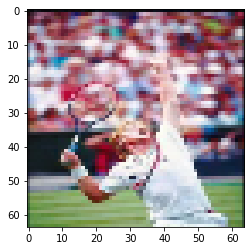

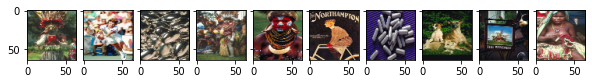



3 query
[ 246  475 1260 1267 1268 1269 1270 1271 1273 1276 1279 1281 1284 1286
 1287 1299 1308 1309 1310 1313 1315 1322 1330 1335 1366 1387 1389 1392
 1425 1427 1431 1750 1751 1791 1834 2354 2499 3518 3532 4083 4439 4468
 4880 5319 5997 6173 7224 7227 7283 7418 8651 8730 8731 8732 8733 8734
 8735 8737 8738 8739 8742 8745 8746 8748 8749 8750 8751 8757 8759 8760
 8761 8762 8763 8764 8766 8767 8769 8771 8772 8773 8774 8779 8780 8781
 8782 8783 8784 8787 8788 8790 8794 8797 8798 8799 8800 8801 8802 8804
 8805 8806 8807 8808 8809 8810 8812 8813 8814 8815 8817 8818]
Duration: 0.03621935844421387


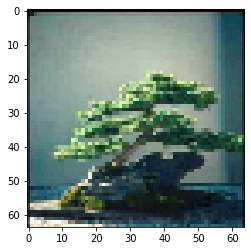

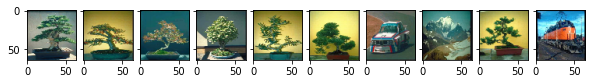



4 query
[ 142  143  488  687 1057 1199 1492 1509 1637 1710 1711 1712 1713 1714
 1715 1716 1717 1718 1719 1720 1721 1722 1723 1724 1725 1726 1727 1728
 1729 1734 1742 1743 1745 1746 1752 1753 1755 1756 1758 1761 1762 1763
 1764 1765 1766 1767 1768 1771 1772 1776 1778 1779 1780 1782 1786 1788
 1797 1894 2007 2013 2047 2384 2510 2613 2619 2622 2640 2655 2772 2784
 3008 3009 3056 3075 3576 3588 3590 4026 4072 4080 4090 4093 4097 4098
 4105 4106 4119 4233 4861 4867 4870 4871 4873 4874 4877 4881 4896 4897
 4900 4909 4946 5339 6074 6164 6215 6223 6224 6232 6233 6278 6488 6808
 6809 6898 7070 7195 7577 7578 7587 7607 7613 7616 7619 7626 7640 8008
 8019 8027 8031 8133 8154 8171 8690 8698 8778]
Duration: 0.04566216468811035


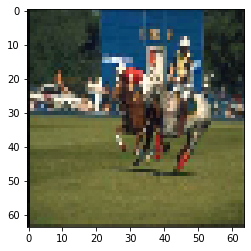

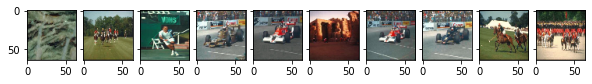



5 query
[  96   99  107  108  113  115  118  119  121  123  127  128  138  148
  150  152  174  177  184  185  188  190  192  194  204  211  215  218
  229  230  232  234  235  236  250  251  255  256  257  259  262  267
  373  402  509  667  688  768  787  793  928  930  949 1047 1062 1079
 1180 1204 1208 1213 1803 1865 1932 1968 2001 2265 2342 2351 2356 2357
 2375 2427 2669 2680 2910 3142 3600 3601 3605 3628 3634 3635 3640 3645
 3669 3670 3672 3703 3985 4050 4052 4087 4117 4234 4263 4271 4272 4287
 5860 5930 5933 6035 6049 6054 6058 6068 6092 6093 6094 6109 6114 6116
 6117 6400 6407 6410 6411 6412 6433 6445 6446 6453 6459 6465 6466 6472
 6474 6475 6500 6559 7155 7261 7381 7385 7392 7398 7400 7403 7404 7405
 7420 7422 7423 7424 7436 7444 7450 7451 7463 7639 7777 7807 7809 7829
 8110 8111 8185 8259 8260 8281 8314 8326 8334 8340 8364 8461 8483 8493
 8649 8680 8697 8707 8711 8720 8768 8920 8925 8940]
Duration: 0.041402578353881836


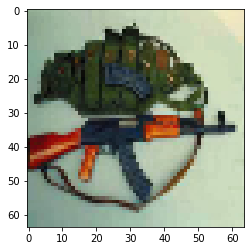

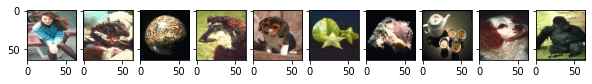

In [259]:
show_retrieve()

In [0]:
def measure_time_on_test(n=None):
  from tqdm.auto import tqdm
  index = load_index()
  durations = []
  if n is not None:
    samples_indices = random.sample([i for i in range(len(TEST_X))], k=n)
    samples = TEST_X[samples_indices]
  else:
    samples = TEST_X
  for sample in tqdm(samples):
    start = time.time()
    retrieve(sample, n=N_RETRIEVE_MEASURE_TIME, index=index)
    end = time.time()
    elapsed = end - start
    durations.append(elapsed)
  print(f'Mean query time: {np.mean(durations)}')
  print(f'Std query time: {np.std(durations)}')

In [189]:
measure_time_on_test()


Mean query time: 0.03391035175323486
Std query time: 0.00282143216351018


In [0]:
def get_ground_truth_by_class():
  d = dict()
  for i in range(len(TRAIN_X)):
    label = TRAIN_Y[i]
    if label not in d:
      d[label] = []
    d[label].append(i)
  return d

def calculate_mapk(n=None):
  from tqdm.auto import tqdm
  index = load_index()
  ground_truth_by_class = get_ground_truth_by_class()
  actual_all = []
  predicted_all = []
  for sample in tqdm(list(zip(TEST_X, TEST_Y))[:n]):
    img, label = sample
    actual = ground_truth_by_class[label]
    n_to_retrieve = len(actual) if N_RETRIEVE_MAPK is None else N_RETRIEVE_MAPK
    predicted = retrieve(img, n=n_to_retrieve, index=index)
    actual_all.append(actual)
    predicted_all.append(predicted)
  mapk = metrics.mapk(actual_all, predicted_all, k=10)
  return mapk

In [191]:
calculate_mapk()

0.2021556746031746

In [227]:
calculate_mapk(10)

0.07466666666666666

In [0]:
from copy import copy
from itertools import combinations
import numpy as np
from pandas import DataFrame
from sklearn.metrics.pairwise import pairwise_distances


class LSH:
    def __init__(self, data):
        self.data = data
        self.model = None

    def __generate_random_vectors(self, num_vector, dim):
        return np.random.randn(dim, num_vector)

    def train(self, num_vector, seed=None):
        dim = self.data.shape[1]
        if seed is not None:
            np.random.seed(seed)

        random_vectors = self.__generate_random_vectors(num_vector, dim)
        powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)

        table = {}

        # Partition data points into bins
        bin_index_bits = (self.data.dot(random_vectors) >= 0)

        # Encode bin index bits into integers
        bin_indices = bin_index_bits.dot(powers_of_two)

        # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
        for data_index, bin_index in enumerate(bin_indices):
            if bin_index not in table:
                # If no list yet exists for this bin, assign the bin an empty list.
                table[bin_index] = []
            # Fetch the list of document ids associated with the bin and add the document id to the end.
            table[bin_index].append(data_index)

        self.model = {'bin_indices': bin_indices, 'table': table,
                      'random_vectors': random_vectors, 'num_vector': num_vector}
        return self

    def __search_nearby_bins(self, query_bin_bits, table, search_radius=2, initial_candidates=set()):
        num_vector = self.model['num_vector']
        powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)

        # Allow the user to provide an initial set of candidates.
        candidate_set = copy(initial_candidates)

        for different_bits in combinations(range(num_vector), search_radius):
            alternate_bits = copy(query_bin_bits)
            for i in different_bits:
                alternate_bits[i] = 1 if alternate_bits[i] == 0 else 0

            # Convert the new bit vector to an integer index
            nearby_bin = alternate_bits.dot(powers_of_two)

            # Fetch the list of documents belonging to the bin indexed by the new bit vector.
            # Then add those documents to candidate_set
            if nearby_bin in table:
                candidate_set.update(table[nearby_bin])

        return candidate_set

    def query(self, query_vec, k, max_search_radius, initial_candidates=set()):

        if not self.model:
            print('Model not yet build. Exiting!')
            exit(-1)

        data = self.data
        table = self.model['table']
        random_vectors = self.model['random_vectors']

        bin_index_bits = (query_vec.dot(random_vectors) >= 0).flatten()

        candidate_set = set()
        # Search nearby bins and collect candidates
        for search_radius in range(max_search_radius + 1):
            candidate_set = candidate_set.union(self.__search_nearby_bins(bin_index_bits, table,
                                                      search_radius, initial_candidates=initial_candidates))
        # Sort candidates by their true distances from the query
        nearest_neighbors = DataFrame({'id': list(candidate_set)})
        candidates = data[np.array(list(candidate_set)), :]
        nearest_neighbors['distance'] = pairwise_distances(candidates, query_vec.reshape(1, -1), metric='cosine').flatten()

        return nearest_neighbors.nsmallest(k, 'distance')

# Сегментация изображений (20 баллов)

Решите задачу сегментации изображений для набора http://www.vision.caltech.edu/Image_Datasets/leaves/leaves.tar Результатом сегментации каждого изображения должно быть изображение с разметкой листа выделенного на черном фоне. Оценка работы алгоритма будет производится по аккуратности выделения сегментов, которые соответствуют листьям. Выделение листьев будет оцениваться по F-мере, вычисленной попиксельно относительно ручной разметки сегментов. В качестве результата выполнения задания помимо исходного кода необходимо прислать полученные результаты сегментации для всех изображений коллекции. (положить их в отдельную папку не изменяя имя файлов leaves/*.jpg > result/*.jpg)

In [0]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [149]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/hw4 -r ./

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip -q hw4/leaves.zip

In [3]:
!ls

gdrive	hw4  leaves  __MACOSX  sample_data


In [0]:
names = np.array(list(sorted(list(os.listdir("leaves"))))[1:])

In [0]:
images = [cv2.cvtColor(cv2.imread("leaves/" + i), cv2.COLOR_BGR2RGB) for i in names]

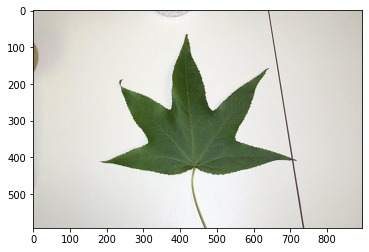

In [13]:
plt.imshow(images[0])

In [0]:
def clear_font(image_):
    split = np.split(image_, 3, axis=2)
    r, g, b = split[0], split[1], split[2]
    rb, gb, bb = np.all(r > [140], axis=-1), np.all(g > [140], axis=-1), np.all(b > [140], axis=-1)
    rs, gs, bs = np.all(r < [30], axis=-1), np.all(g < [30], axis=-1), np.all(b < [30], axis=-1)
    big_ = rb & bb & gb
    small_ = rs & gs & bs
    gSr =  np.squeeze(g < r)
    gSb =  np.squeeze(g < b)
    g_not_biggest = gSr | gSb
    return big_ | small_ | g_not_biggest

In [0]:
from tqdm.auto import tqdm

In [114]:
images_cleared = []
for id in tqdm(range(len(images))):
    img_ = images[id].copy()
    img_[clear_font(img_)] = [0, 0, 0]
    images_cleared.append(img_)


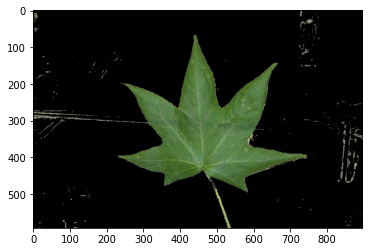

In [136]:
plt.imshow(images_cleared[36])

In [0]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage import io

In [0]:
def segmentation(images_):
    result = []

    for image in tqdm(images_):
        slic_ = slic(img_as_float(image), n_segments=7, compactness=10, sigma=1)
        w, h = slic_.shape[0], slic_.shape[1]
        leaf_id = slic_[w // 2][h // 2] # leaf at center

        res_i = image.copy()
        res_i[slic_ != leaf_id] = [0, 0, 0]
        result.append(res_i)

    return result

In [121]:
segmented_leafs = segmentation(images_cleared)

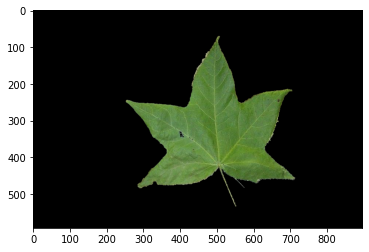

In [193]:
plt.imshow(segmented_leafs[50])

In [132]:
!mkdir result
for i, image in tqdm(enumerate(segmented_leafs)):
        cv2.imwrite("result/" + names[i], image)

In [0]:
!zip -r result.zip result